# Basis pursuit with a single "Gaussian" observation

Let $y\in\mathbb{R}, \sigma\in\mathbb{R}_+^*$ and consider 

$$
\underset{u\in L^2(\mathbb{R}^2)}{\text{inf}} ~ |Du|(\mathbb{R}^2) \text{ s.t. } 
\int_{\mathbb{R}^2}\text{exp}(-\frac{||x||^2}{2\sigma^2}) ~ u(x) ~ dx = y
$$

One can show that there exists a solution of the form $u_{\alpha,R}=a\,\mathbb{1}_{B(0, R)}$

Now one can also show that $u_{\alpha,R}$ is a solution if and only if $R$ satisfies $1+\frac{R^2}{\sigma^2}=\text{exp}(\frac{R^2}{2\sigma^2})$ and 
$a=y \, / \, [2\pi\sigma^2(1-\text{exp}(-\frac{R^2}{2\sigma^2}))]$

Let us investigate whether we are able to recover this result numerically or not ...

## Numerics

PyCheeger commit : 872cdb0a2c9deef14c3d99b0e6805292eba24ca6
<br/>
tvsfw commit : c42d516501c7a0ee761be79a6f7b56927a0a9f69

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import pi, exp
from scipy.optimize import minimize

from pycheeger import compute_cheeger, Disk
from tvsfw import GaussianPolynomial, SampledGaussianKernel, WeightedIndicatorFunction, SimpleFunction

In [2]:
sigma = 0.3
alpha = 1e-10  # regularization parameter, our algorithm cannot directly solve the basis pursuit problem

In [3]:
r_opt = minimize(lambda x: x / (1 - exp(-x**2 / (2 * sigma**2))), sigma).x[0]
print("theoretical optimal radius: {}".format(r_opt))

theoretical optimal radius: 0.47556030828963447


In [4]:
y = 2 * pi * sigma ** 2 * (1 - exp(-r_opt ** 2/ (2 * sigma ** 2)))  # we here define y so that a = 1

In [5]:
grid = np.array([[[0, 0]]])
phi = SampledGaussianKernel(grid, sigma)
eta = GaussianPolynomial(grid, np.array([[y]]), sigma)

4.914515056610299e-05
1.0325142163802028


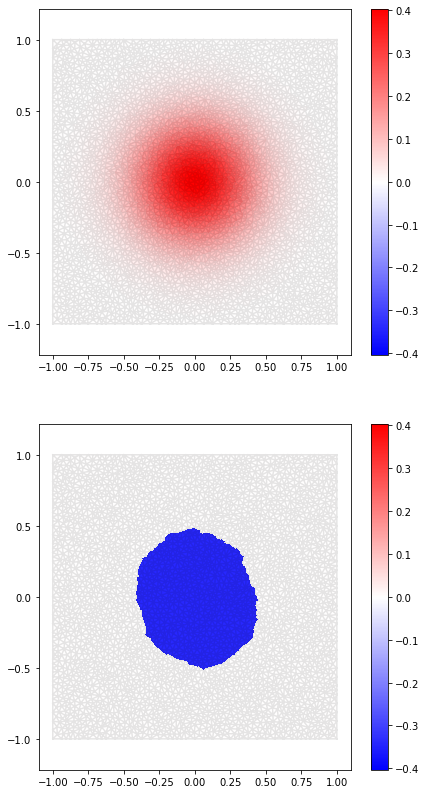

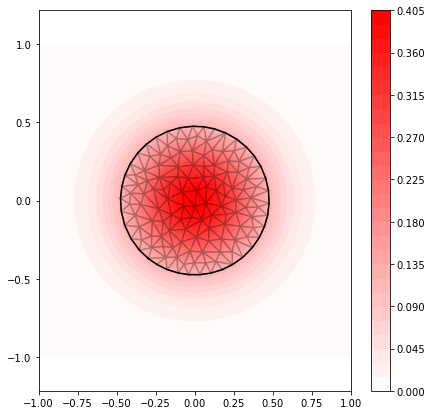

In [6]:
E, _, _ = compute_cheeger(eta, max_tri_area=0.001, max_primal_dual_iter=20000, max_iter=500, convergence_tol=1e-3,
                          plot_results=True)

In [7]:
u_hat = SimpleFunction([WeightedIndicatorFunction(0, E)])

No need to perform a LASSO to get the weight, it is entirely determined (single observation)

In [8]:
obs = u_hat.compute_obs(phi, version=1)
coeff = np.sum(obs[0], axis=0)[0, 0]
weight = y / coeff
u_hat.atoms = [WeightedIndicatorFunction(weight, E)]

After adding a new atom to the support and performing a LASSO on the weights, we get the weighted indicator function of a disk with weight and radius given above.

<br/>

We can check that if we denote this function $\hat{u}$ we have 
$$\int_{\mathbb{R}^2}\hat{u}~\text{exp}(-\frac{||x||^2}{2\sigma^2})~dx=y$$


In [9]:
radius = np.mean(np.linalg.norm(u_hat.atoms[0].support.boundary_vertices, axis=1))

print("radius: {}".format(radius))
print("weight: {}".format(weight))

radius: 0.4756254331144813
weight: 1.0021926183264365


In [10]:
print("integral (numerical): {}".format(u_hat.compute_obs(phi)[0, 0]))
print("integral (analytical): {}".format(weight * 2 * pi * sigma ** 2 * (1 - exp(-radius**2 / (2*sigma**2)))))
print("y: {}".format(y))

integral (numerical): 0.40451062900130746
integral (analytical): 0.4054530771740908
y: 0.4045106290013075


The estimated radius moreover approximately satisfies the optimality equation given at the beginning

In [11]:
print(1 + radius ** 2 / sigma ** 2)
print(exp(radius ** 2 / (2 * sigma ** 2)))

3.513550584725977
3.514071344053896
